# Import library

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

 # Data Preprocessing


In [15]:
training_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
print(f'Found {training_set.cardinality().numpy()} batches of training data')


Found 70295 files belonging to 38 classes.
Found 2197 batches of training data


In [16]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
print(f'Found {validation_set.cardinality().numpy()} batches of validation data')


Found 17572 files belonging to 38 classes.
Found 550 batches of validation data


In [17]:
# Importing required libraries
import tensorflow as tf
from tensorflow.keras import layers, models


# Attention Mechanism

In [18]:
# Squeeze-and-Excitation block definition
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]  # Number of filters in the input tensor
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = layers.multiply([input_tensor, se])
    return x


# CNN Architecture

In [19]:
# Input layer
inputs = layers.Input(shape=(128, 128, 3))

# First Convolutional Layer Block
x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

# Attention block after the first convolutional layer
x = se_block(x)


In [20]:
# Second Convolutional Layer Block
x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

# Attention block after the second convolutional layer
x = se_block(x)


In [21]:
# Third Convolutional Layer Block
x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)


In [22]:
# Fourth Convolutional Layer Block
x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)


In [23]:
# Fifth Convolutional Layer Block
x = layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)


#  DNN Block

In [24]:
# Flattening
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)

# DNN Block (Dense Layer)
x = layers.Dense(units=1500, activation='relu')(x)
x = layers.Dropout(0.4)(x)


In [25]:
# Output Layer
outputs = layers.Dense(units=38, activation='softmax')(x)


# Model Compilation and Summary

In [26]:
model = models.Model(inputs=inputs, outputs=outputs)
# Compiling the model with the current Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 126, 126,  │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 63, 63,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_5[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1, 1, 2)   │         64 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 1, 32)  │         64 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 63, 63,    │          0 │ max_pooling2d_5[… │
│ (Multiply)          │ 32)               │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 63, 63,    │     18,496 │ multiply_2[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 61, 61,    │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 30, 30,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_6[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1, 4)   │        256 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 1, 64)  │        256 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 30, 30,    │          0 │ max_pooling2d_6[… │
│ (Multiply)          │ 64)               │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 30, 30,    │     73,856 │ multiply_3[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_14[0][0] 

 Total params: 7,843,402 (29.92 MB)

 Trainable params: 7,843,402 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [27]:
# Training the model
training_history = model.fit(x=training_set,
                              validation_data=validation_set,
                              epochs=10)


Epoch 1/10


I0000 00:00:1727868919.945108     110 service.cc:145] XLA service 0x7e94540041c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727868919.945170     110 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727868919.945176     110 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   2/2197 ━━━━━━━━━━━━━━━━━━━━ 2:37 72ms/step - accuracy: 0.0000e+00 - loss: 3.6756   

I0000 00:00:1727868934.468123     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 193s 79ms/step - accuracy: 0.3803 - loss: 2.1874 - val_accuracy: 0.8459 - val_loss: 0.4721
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.8489 - loss: 0.4779 - val_accuracy: 0.8856 - val_loss: 0.3495
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 116s 53ms/step - accuracy: 0.9074 - loss: 0.2794 - val_accuracy: 0.9247 - val_loss: 0.2217
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.9356 - loss: 0.1888 - val_accuracy: 0.9388 - val_loss: 0.1801
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.9540 - loss: 0.1369 - val_accuracy: 0.9561 - val_loss: 0.1374
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.9630 - loss: 0.1092 - val_accuracy: 0.9634 - val_loss: 0.1184
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.9707 - loss: 0.0884 - val_accuracy: 0.9571 - val_loss: 0.1332
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 114s 52ms/step - accuracy: 0.9766 - lo

# Cheak The accuracy

In [28]:
# Evaluate Training Set Accuracy
train_loss, train_acc = model.evaluate(training_set)
print('Training accuracy:', train_acc)

# Evaluate Validation Set Accuracy
val_loss, val_acc = model.evaluate(validation_set)
print('Validation accuracy:', val_acc)


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9866 - loss: 0.0413
Training accuracy: 0.9880361557006836
550/550 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9666 - loss: 0.1237
Validation accuracy: 0.9646596908569336


# Save Model

In [29]:
# Saving the model
model.save('trained_plant_disease_model_ahmed.keras')


In [30]:
training_history.history #Return Dictionary of history

{'accuracy': [0.5967991948127747,
  0.8694217205047607,
  0.9173056483268738,
  0.9406927824020386,
  0.9564406871795654,
  0.9647058844566345,
  0.9711359143257141,
  0.9766839742660522,
  0.9790738821029663,
  0.9827299118041992],
 'loss': [1.3614240884780884,
  0.4091539680957794,
  0.2514108717441559,
  0.1754467785358429,
  0.13011467456817627,
  0.10478170216083527,
  0.08755267411470413,
  0.0700477659702301,
  0.0630531758069992,
  0.05380484461784363],
 'val_accuracy': [0.8459481000900269,
  0.8856135010719299,
  0.9247097373008728,
  0.9388231039047241,
  0.9560664892196655,
  0.963350772857666,
  0.9571477174758911,
  0.9689847230911255,
  0.9611313343048096,
  0.9646596908569336],
 'val_loss': [0.47205519676208496,
  0.34947270154953003,
  0.22170747816562653,
  0.18005917966365814,
  0.13738150894641876,
  0.11839297413825989,
  0.13318423926830292,
  0.09761416912078857,
  0.13281482458114624,
  0.12896357476711273]}

# Recording Training History

In [31]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

# Plotting the accuracy results

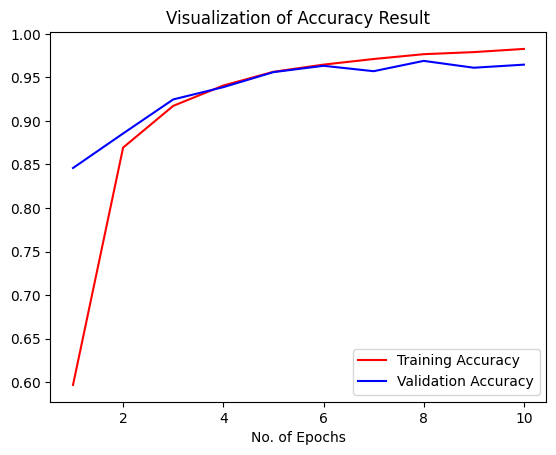

In [32]:
 epochs = [i for i in range(1,11)]
plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

# Predictions and Evaluation

In [33]:
class_name = validation_set.class_names

# Load Test Dataset

In [42]:
test_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


#  Make predictions

In [43]:
y_pred = model.predict(test_set)
y_pred,y_pred.shape

17572/17572 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step


(array([[1.0000000e+00, 1.7468544e-09, 9.0145408e-12, ..., 1.0526777e-17,
         1.9687028e-17, 5.7377714e-14],
        [1.0000000e+00, 6.9258410e-10, 9.6170813e-14, ..., 2.8281564e-19,
         1.9536206e-17, 2.5509302e-16],
        [1.0000000e+00, 4.8848356e-08, 1.0032809e-10, ..., 1.2140576e-18,
         8.9078336e-16, 4.4533013e-13],
        ...,
        [1.4954353e-10, 2.8100805e-15, 1.9787423e-11, ..., 1.6658468e-13,
         2.2086138e-14, 9.9999857e-01],
        [9.8748201e-09, 4.7580039e-13, 2.8757421e-10, ..., 3.1300423e-10,
         8.4076478e-12, 9.9999940e-01],
        [2.2939528e-15, 5.7704838e-19, 5.0906362e-16, ..., 1.9345751e-18,
         4.9083485e-17, 1.0000000e+00]], dtype=float32),
 (17572, 38))

In [44]:
predicted_categories = tf.argmax(y_pred, axis=1)

In [45]:
predicted_categories

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37])>

# Get true categories

In [46]:
true_categories= tf.concat([y for x,y in test_set],axis=0)
true_categories

<tf.Tensor: shape=(17572, 38), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [47]:
Y_true = tf.argmax(true_categories, axis=1)
Y_true

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37])>

# Classification report

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [54]:
print(classification_report(Y_true, predicted_categories, target_names=class_name))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.92      0.98      0.95       504
                                 Apple___Black_rot       0.98      0.97      0.98       497
                          Apple___Cedar_apple_rust       0.98      0.95      0.97       440
                                   Apple___healthy       0.95      0.98      0.96       502
                               Blueberry___healthy       0.97      0.97      0.97       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       421
                 Cherry_(including_sour)___healthy       0.98      0.99      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.92      0.93       410
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.95      0.96      0.

In [55]:
cm = confusion_matrix(Y_true, predicted_categories)
cm

array([[496,   3,   0, ...,   0,   0,   0],
       [  5, 483,   0, ...,   0,   0,   0],
       [  1,   2, 419, ...,   1,   0,   1],
       ...,
       [  0,   0,   0, ..., 486,   0,   0],
       [  0,   0,   0, ...,   0, 445,   1],
       [  0,   0,   0, ...,   0,   0, 477]])

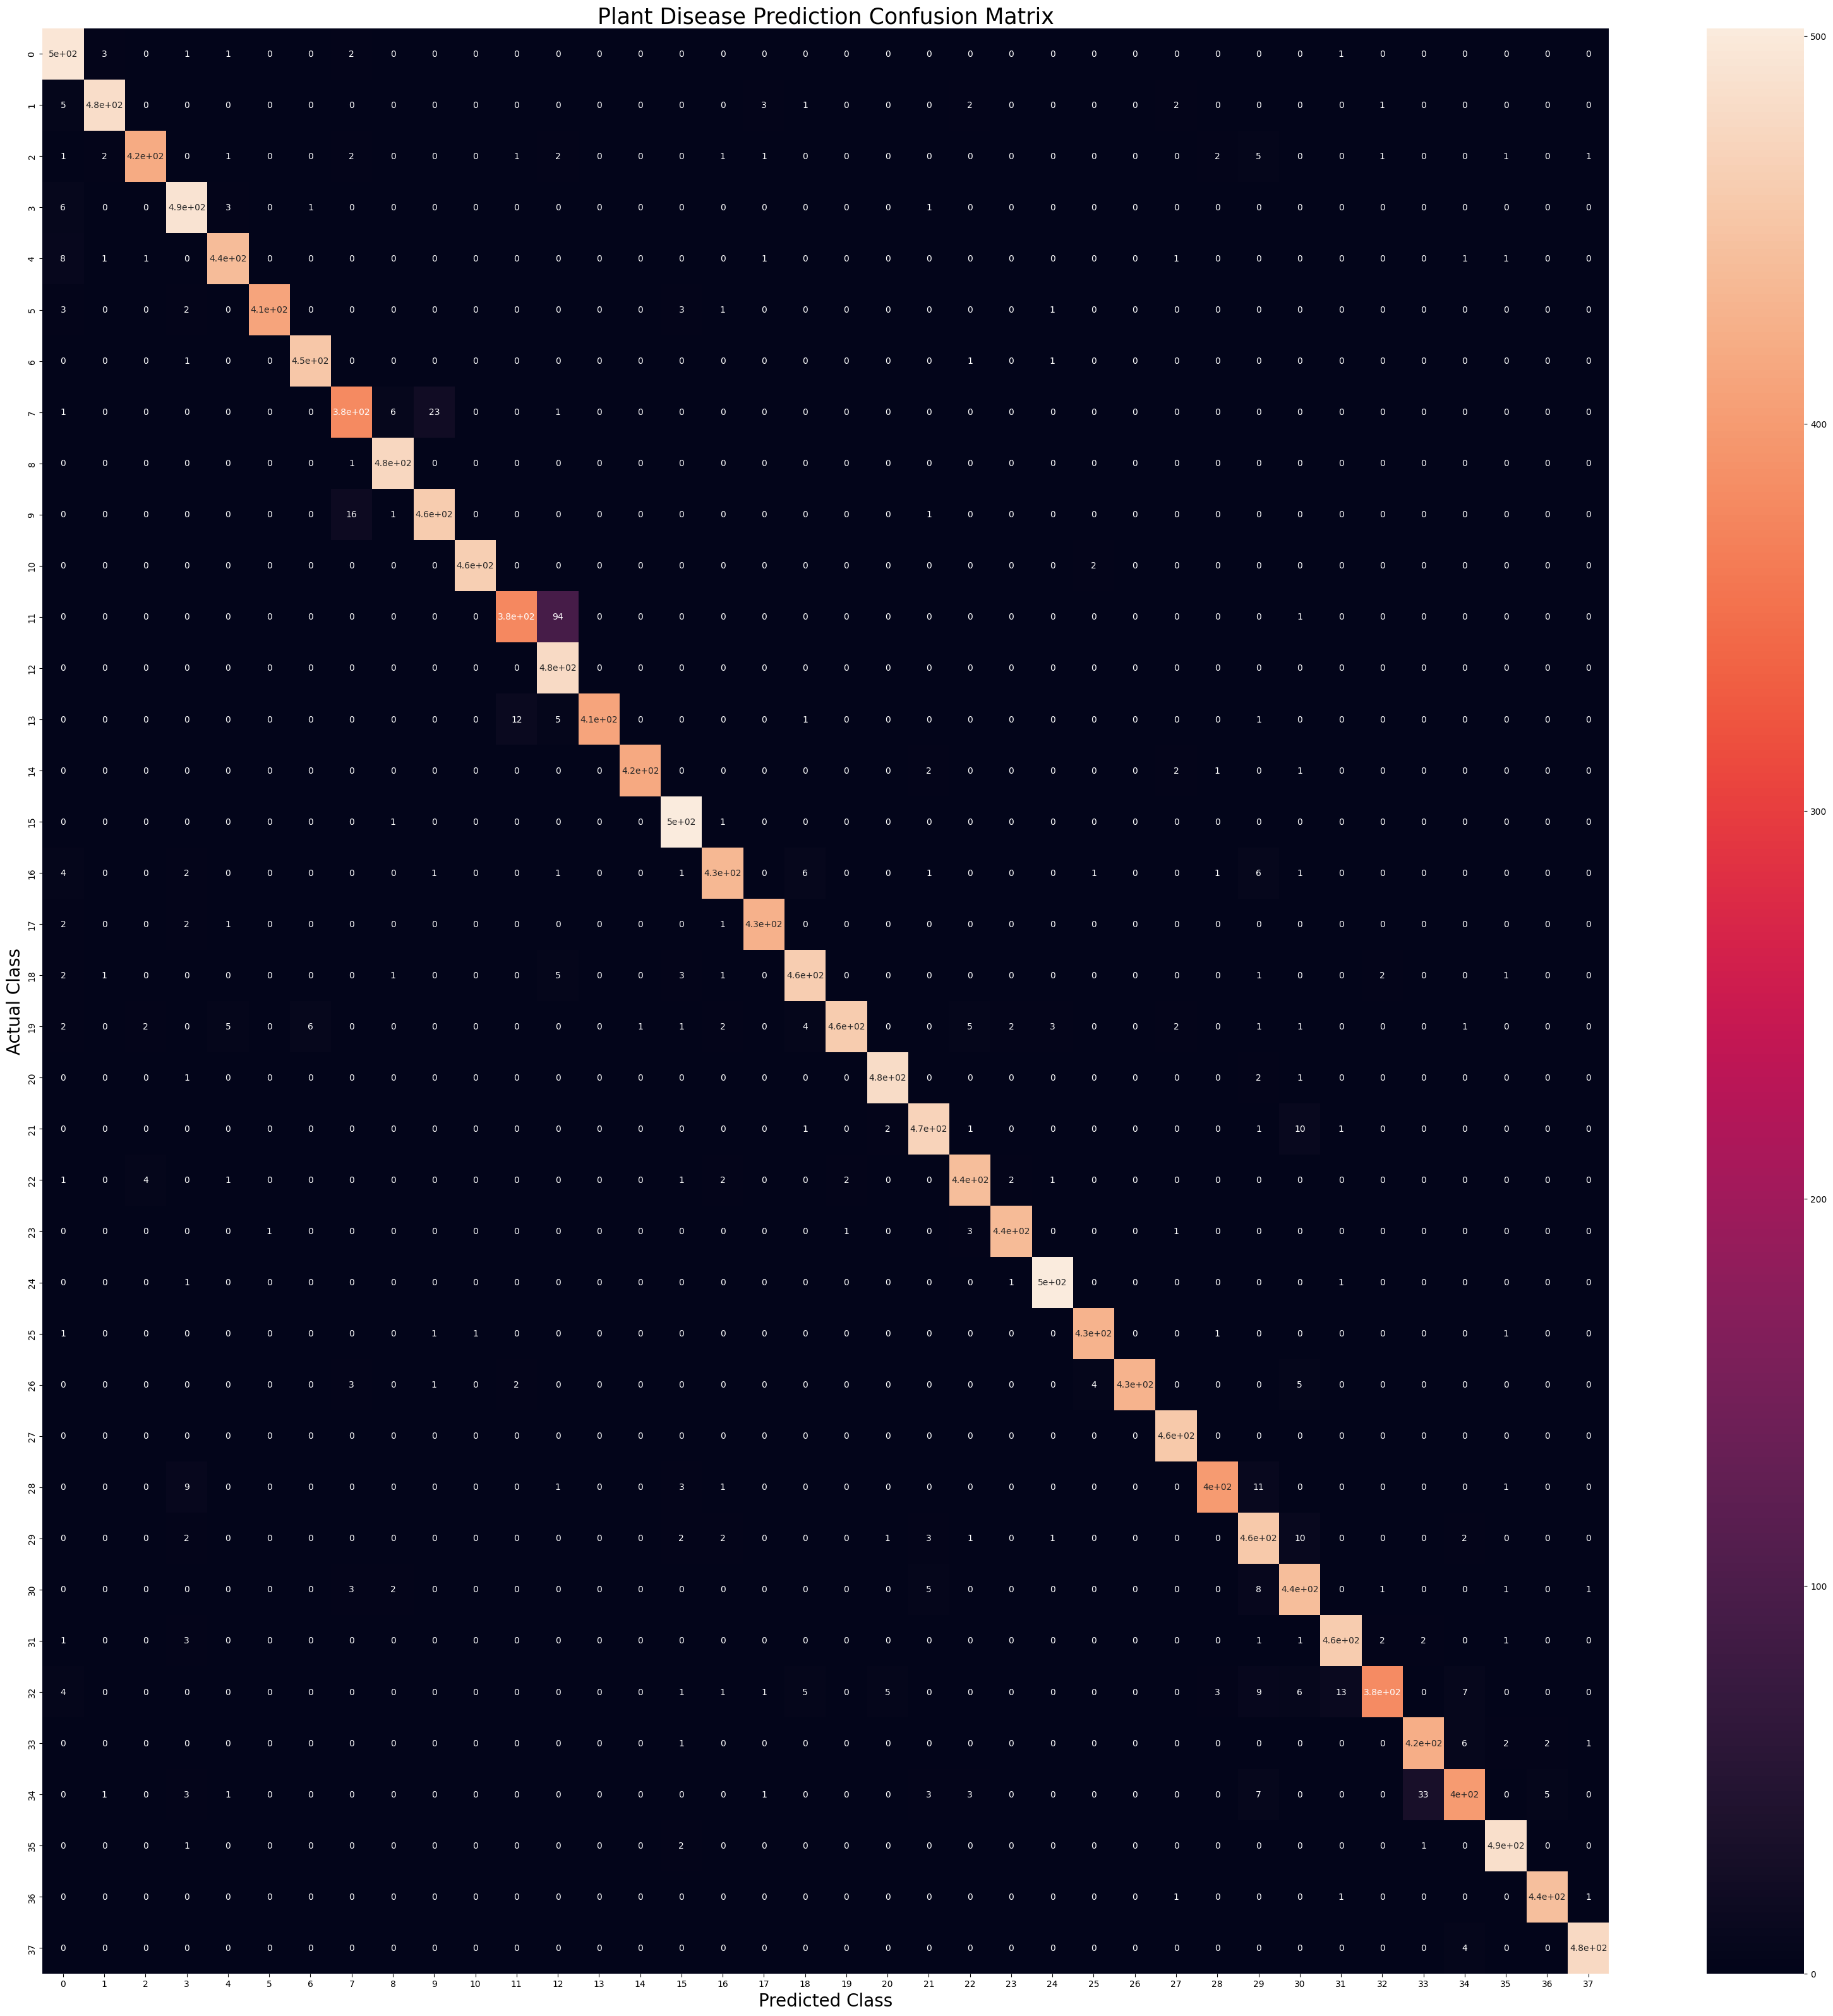

In [56]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()